In [1]:
import numpy as np
eps_values = np.logspace(-5, -1, num=12)   # 1e-4, 2e-4, … , 1e-1
print(eps_values)

print()

eps = eps_values[0]
print(f'eps value is ',eps)


[1.00000000e-05 2.31012970e-05 5.33669923e-05 1.23284674e-04
 2.84803587e-04 6.57933225e-04 1.51991108e-03 3.51119173e-03
 8.11130831e-03 1.87381742e-02 4.32876128e-02 1.00000000e-01]

eps value is  1e-05


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define the ODE systems
def fast_system(y, t, eps):
    x, y = y
    dxdt = eps
    dydt = x + y**2
    return [dxdt, dydt]

def slow_system(y, tau, eps):
    x, y = y
    dx_dtau = 1
    dy_dtau = (x + y**2) / eps
    return [dx_dtau, dy_dtau]

# Initial and ending points
x_init, y_init = -5, -5
x_end, y_end = 0, 2

# Time parameters
t_end = 10
tau_end = 4.8
#eps = 0.001
t = np.linspace(0, t_end, 100)
tau = np.linspace(0, tau_end, 100)
t2  =  np.linspace(0,-t_end, 100)

# Convert numpy arrays to PyTorch tensors
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

# Neural network model for the fast system
num_nrn = 5

class FastSystemPINN(nn.Module):
    def __init__(self):
        super(FastSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural network model for the slow system
class SlowSystemPINN(nn.Module):
    def __init__(self):
        super(SlowSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class FastSystemPINN2(nn.Module):
    def __init__(self):
        super(FastSystemPINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

## The first plot:

In [3]:
phys_weight = 1

def loss_func_fast(model, t_tensor, x_init, y_init,\
                                   xf_end, yf_end, eps):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast = dx_dt - eps
    residual2_fast = dy_dt - (x_pred_fast + y_pred_fast**2)  
    
    #residual3_fast = 0 #dx_dt
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) 
    physics_loss_fast = torch.mean(residual1_fast**2+ residual2_fast**2 )

    boundary_loss_fast = torch.square(x_pred_fast[-1] - xf_end) +\
                         torch.square(y_pred_fast[-1] - yf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, xs_init, ys_init, xs_end, ys_end, eps):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = dx_dtau  - 1
    residual2_slow = eps * dy_dtau - (x_pred_slow + y_pred_slow ** 2)
    init_loss_slow = torch.square(x_pred_slow[0] - xs_init) +\
                     torch.square(y_pred_slow[0] - ys_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - xs_end) +\
                         torch.square(y_pred_slow[-1] - ys_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, x_end, y_end,\
                                   xf2_end, yf2_end, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast2 = dx_dt2 - eps
    residual2_fast2 = dy_dt2 - (x_pred_fast2 + y_pred_fast2**2)     
    #residual3_fast2 = 0 # dx_dt2 
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                     torch.square(y_pred_fast2[0] - y_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2+ residual2_fast2**2 )

    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - xf2_end) +\
                         torch.square(y_pred_fast2[-1] - yf2_end) 
        
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 +\
                       boundary_loss_fast2 

    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, xf_end, yf_end,\
                    xs_init, ys_init, xs_end, ys_end,\
                    x_end, y_end, xf2_end, yf2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init,\
                                                   xf_end, yf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               xs_init, ys_init, xs_end, ys_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end,\
                                                   xf2_end, yf2_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss



Epoch 0, Total Loss: 64.39453581077993
Epoch 4000, Total Loss: 0.032612037693247185
Epoch 8000, Total Loss: 0.0022737294869773763
Epoch 12000, Total Loss: 0.0015235439433868153
Epoch 16000, Total Loss: 0.0013086953925321551
Epoch 20000, Total Loss: 0.001269741522516711


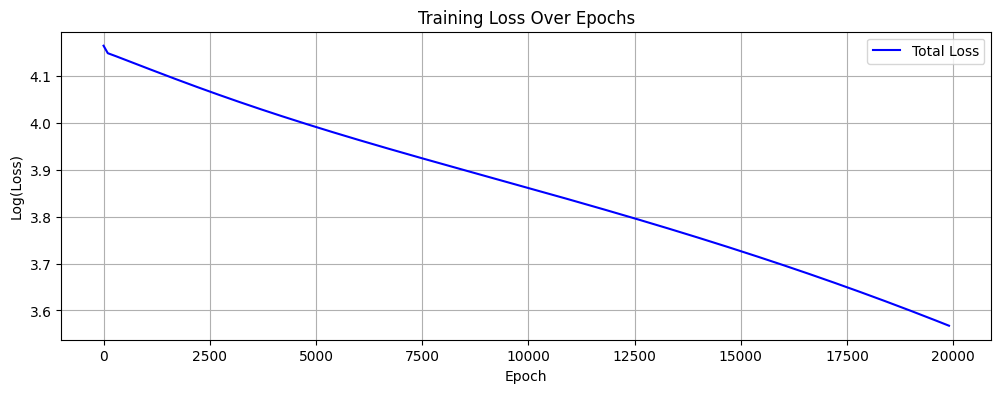

In [4]:
if __name__ == '__main__':
    model_fast  = FastSystemPINN().to(torch.float64)
    model_slow  = SlowSystemPINN().to(torch.float64)
    model_fast2 = FastSystemPINN2().to(torch.float64) 
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    
    loss_values = []
    epoch_num = 20000
    
    xf_end, yf_end = np.random.random(), np.random.random()   
    xs_init, ys_init = np.random.random(), np.random.random()
    xs_end, ys_end = np.random.random(), np.random.random()
    xf2_end, yf2_end = np.random.random(), np.random.random()

    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, xf_end, yf_end,\
                                     xs_init, ys_init, xs_end, ys_end,\
                                     x_end, y_end, xf2_end, yf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()
        
        with torch.no_grad():
            x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end  = x_pred_slow[0], y_pred_slow[0]
            xs_init, ys_init = x_pred_fast[-1], y_pred_fast[-1]
            xs_end,  ys_end  = x_pred_fast2[-1], y_pred_fast2[-1]
            xf2_end, yf2_end = x_pred_slow[-1],  y_pred_slow[-1]

        if epoch % 4000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        
        loss_values.append(loss_total.item())

    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 100), np.log(loss_values[:epoch_num//100]), 'b', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()




## The second plot: 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initial and ending points
u_init, v_init = -4, 0.0
u_end, v_end = 0, 2

# Time parameters
t_end = 10
tau_end = 4.0
#eps = 0.001
t = np.linspace(0, t_end, 100)
tau = np.linspace(0, tau_end, 100)
t2  =  np.linspace(0,-t_end, 100)

# Convert numpy arrays to PyTorch tensors
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

# Neural network model for the fast system
num_nrn = 5

class Fast_System_PINN(nn.Module):
    def __init__(self):
        super(Fast_System_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        u = F.tanh(self.fc1(t))
        u = F.tanh(self.fc2(u))
        u = self.fc3(u)
        return u

# Neural network model for the slow system
class Slow_System_PINN(nn.Module):
    def __init__(self):
        super(Slow_System_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, tau):
        v = F.tanh(self.fc1(tau))
        v = F.tanh(self.fc2(v))
        v = self.fc3(v)
        return v

# Neural network model for the second fast system
class Fast_System_PINN2(nn.Module):
    def __init__(self):
        super(Fast_System_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        u = F.tanh(self.fc1(t))
        u = F.tanh(self.fc2(u))
        u = self.fc3(u)
        return u


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

phys_weight = 1

def loss_func_fast(model, t_tensor, u_init, v_init,\
                                   uf_end, vf_end, eps):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    u_pred_fast, v_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(u_pred_fast, requires_grad=True)  
    du_dt = torch.autograd.grad(u_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dt = torch.autograd.grad(v_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast = du_dt - eps
    residual2_fast = dv_dt - (u_pred_fast + v_pred_fast**2)  
    
    residual3_fast = 0 #du_dt
    
    init_loss_fast = torch.square(u_pred_fast[0] - u_init) +\
                     torch.square(v_pred_fast[0] - v_init) 
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 + residual3_fast**2)

    boundary_loss_fast = torch.square(u_pred_fast[-1] - uf_end) +\
                         torch.square(v_pred_fast[-1] - vf_end) 
        
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast +\
                      boundary_loss_fast 

    return total_loss_fast


def loss_func_slow(model, tau_tensor, us_init, vs_init, us_end, vs_end, eps):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    u_pred_slow, v_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)   
    
    ones = torch.ones_like(u_pred_slow, requires_grad=True)
    du_dtau = torch.autograd.grad(u_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dtau = torch.autograd.grad(v_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_slow = du_dtau  - 1
    residual2_slow = eps * dv_dtau - (u_pred_slow + v_pred_slow ** 2) #u_pred_slow + v_pred_slow ** 2
    
    init_loss_slow = torch.square(u_pred_slow[0] - us_init) +\
                     torch.square(v_pred_slow[0] - vs_init) 
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2)
    
    boundary_loss_slow = torch.square(u_pred_slow[-1] - us_end) +\
                         torch.square(v_pred_slow[-1] - vs_end)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, u_end, v_end,\
                                   uf2_end, vf2_end, eps):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    u_pred_fast2, v_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    
    ones = torch.ones_like(u_pred_fast2, requires_grad=True)  
    du_dt2 = torch.autograd.grad(u_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dv_dt2 = torch.autograd.grad(v_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    
    residual1_fast2 = du_dt2 - eps
    residual2_fast2 = dv_dt2 - (u_pred_fast2 + v_pred_fast2**2)     
    residual3_fast2 = 0 # du_dt2 
    
    init_loss_fast2 = torch.square(u_pred_fast2[0] - u_end) +\
                     torch.square(v_pred_fast2[0] - v_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2)

    boundary_loss_fast2 = torch.square(u_pred_fast2[-1] - uf2_end) +\
                         torch.square(v_pred_fast2[-1] - vf2_end) 
        
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 +\
                       boundary_loss_fast2 

    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    u_init, v_init, uf_end, vf_end,\
                    us_init, vs_init, us_end, vs_end,\
                    u_end, v_end, uf2_end, vf2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, u_init, v_init,\
                                                   uf_end, vf_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               us_init, vs_init, us_end, vs_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, u_end, v_end,\
                                                   uf2_end, vf2_end, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss


Epoch 0, Total Loss: 30.51831517641316
Epoch 4000, Total Loss: 0.005527203085331445
Epoch 8000, Total Loss: 0.000691511971852753
Epoch 12000, Total Loss: 0.00029445874320875153
Epoch 16000, Total Loss: 0.00014374926605087521
Epoch 20000, Total Loss: 0.00011137154933584535


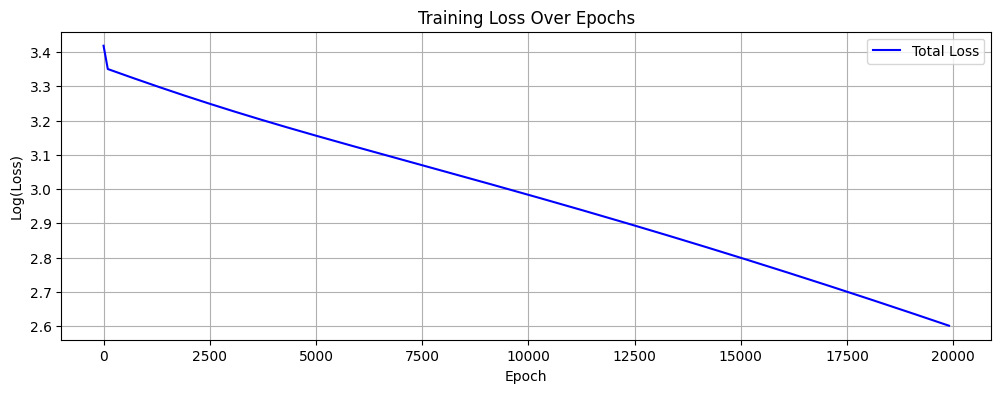

In [7]:
if __name__ == '__main__':
    model_fast  = Fast_System_PINN().to(torch.float64)
    model_slow  = Slow_System_PINN().to(torch.float64)
    model_fast2 = Fast_System_PINN2().to(torch.float64) 
    
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    
    loss_values = []
    epoch_num = 20000
    
    uf_end, vf_end = np.random.random(), np.random.random()   
    us_init, vs_init = np.random.random(), np.random.random()
    us_end, vs_end = np.random.random(), np.random.random()
    uf2_end, vf2_end = np.random.random(), np.random.random()

    for epoch in range(epoch_num + 1):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     u_init, v_init, uf_end, vf_end,\
                                     us_init, vs_init, us_end, vs_end,\
                                     u_end, v_end, uf2_end, vf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()
        
        with torch.no_grad():
            u_pred_fast, v_pred_fast = model_fast(t_tensor).numpy().T
            u_pred_slow, v_pred_slow = model_slow(tau_tensor).numpy().T
            u_pred_fast2, v_pred_fast2 = model_fast2(t2_tensor).numpy().T

            uf_end,  vf_end  = u_pred_slow[0], v_pred_slow[0]
            us_init, vs_init = u_pred_fast[-1], v_pred_fast[-1]
            us_end,  vs_end  = u_pred_fast2[-1], v_pred_fast2[-1]
            uf2_end, vf2_end = u_pred_slow[-1],  v_pred_slow[-1]

        if epoch % 4000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        
        loss_values.append(loss_total.item())

    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 100), np.log(loss_values[:epoch_num//100]), 'b', label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


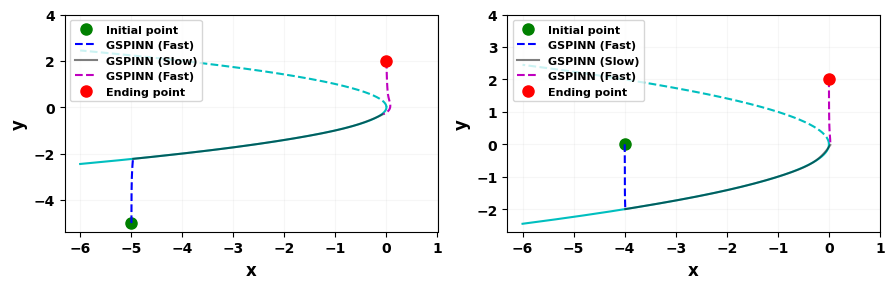

Shape of x_pred_fast: (100,)
Shape of x_pred_slow: (100,)
Shape of u_pred_fast: (100,)
Shape of u_pred_slow: (100,)


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Define the cyan curve
y_curve = np.linspace(-np.sqrt(6), np.sqrt(6), 400)
x_curve = -y_curve**2

# Separate the curve into two parts
y_curve_below = y_curve[y_curve <= 0]
x_curve_below = x_curve[y_curve <= 0]
y_curve_above = y_curve[y_curve > 0]
x_curve_above = x_curve[y_curve > 0]

# Plot the curve with different styles
ax1.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
ax1.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
ax1.plot(x_init, y_init, 'go', label='Initial point', markersize=8)
ax1.plot(x_pred_fast, y_pred_fast, 'b--', label='GSPINN (Fast)')
ax1.plot(x_pred_slow, y_pred_slow, 'k-', label='GSPINN (Slow)', alpha=0.5)
ax1.plot(x_pred_fast2, y_pred_fast2, 'm--', label='GSPINN (Fast)')
ax1.plot(x_end, y_end, 'ro', label='Ending point', markersize=8)

# Set labels and legend for the first subplot with thicker font
ax1.set_xlabel('x', fontsize=12, fontweight='bold')
ax1.set_ylabel('y', fontsize=12, fontweight='bold')
ax1.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
ax1.grid(True, alpha=0.1)
ax1.set_xlim( right=1)
ax1.set_ylim(top=4)

plt.setp(ax1.get_ymajorticklabels(), fontweight='bold')
plt.setp(ax1.get_yminorticklabels(), fontweight='bold')
plt.setp(ax1.get_xmajorticklabels(), fontweight='bold')
plt.setp(ax1.get_xminorticklabels(), fontweight='bold')

# Plot the curve with different styles in the second subplot
ax2.plot(x_curve_below, y_curve_below, 'c-')  # Solid line below the origin
ax2.plot(x_curve_above, y_curve_above, 'c--')  # Dashed line above the origin

# Plot for the initial and predicted points
ax2.plot(u_init, v_init, 'go', label='Initial point', markersize=8)
ax2.plot(u_pred_fast, v_pred_fast, 'b--', label='GSPINN (Fast)')
ax2.plot(u_pred_slow, v_pred_slow, 'k-', label='GSPINN (Slow)', alpha=0.5)
ax2.plot(u_pred_fast2, v_pred_fast2, 'm--', label='GSPINN (Fast)')
ax2.plot(u_end, v_end, 'ro', label='Ending point', markersize=8)

# Set labels and legend for the second subplot with thicker font
ax2.set_xlabel('x', fontsize=12, fontweight='bold')
ax2.set_ylabel('y', fontsize=12, fontweight='bold')
ax2.legend(prop={'size': 8, 'weight': 'bold'}, loc='upper left')
ax2.grid(True, alpha=0.1)
ax2.set_xlim( right=1)
ax2.set_ylim(top=4)

plt.setp(ax2.get_ymajorticklabels(), fontweight='bold')
plt.setp(ax2.get_yminorticklabels(), fontweight='bold')
plt.setp(ax2.get_xmajorticklabels(), fontweight='bold')
plt.setp(ax2.get_xminorticklabels(), fontweight='bold')


plt.tight_layout()
plt.show()

# Print the shapes of the prediction arrays
shape_x_pred_fast = x_pred_fast.shape
print("Shape of x_pred_fast:", shape_x_pred_fast)
shape_x_pred_slow = x_pred_slow.shape
print("Shape of x_pred_slow:", shape_x_pred_slow)

shape_u_pred_fast = u_pred_fast.shape
print("Shape of u_pred_fast:", shape_u_pred_fast)
shape_u_pred_slow = u_pred_slow.shape
print("Shape of u_pred_slow:", shape_u_pred_slow)


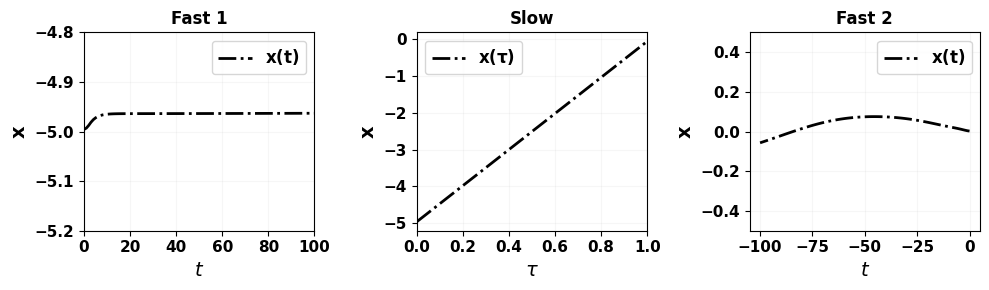

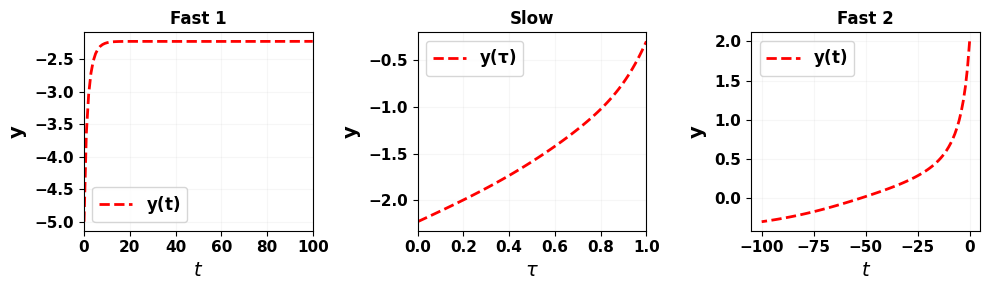

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ── your data here ───────────────────────────────────────────────────────────────
# t, t2:        arrays originally spanning 0 … 10
# τ (tau):       array originally spanning 0 … 4.8
# x_pred_fast,  x_pred_slow,  x_pred_fast2
# y_pred_fast,  y_pred_slow,  y_pred_fast2
# -----------------------------------------------------------------------------

# rescale axes ------------------------------------------------------------------
tau_unit = tau / 4     # 0–4.8  →  0–1
t_pct    = t  * 10        # 0–10   →  0–100
t2_pct   = t2 * 10

# helper: bold all tick labels --------------------------------------------------
def bold_ticks(ax, size=11):
    ax.figure.canvas.draw()      # make sure the Text objects exist
    for lbl in (ax.get_xticklabels(minor=False) + ax.get_xticklabels(minor=True) +
                ax.get_yticklabels(minor=False) + ax.get_yticklabels(minor=True)):
        lbl.set_fontweight('bold')
        lbl.set_fontsize(size)

# ── 1st figure :  x ------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# fast layer 1
axs[0].plot(t_pct, x_pred_fast, '-.', c='k', lw=2, label=r'$\mathbf{x(t)}$')
axs[0].set_xlim(0, 100);  axs[0].set_ylim(-5.2, -4.8)
axs[0].set_xlabel(r'$t$ ',fontsize =14, fontweight='bold')  
axs[0].set_ylabel(r'$\mathbf{x}$', fontsize =14, fontweight='bold')
axs[0].set_title('Fast 1', fontweight='bold');     axs[0].grid(alpha=0.1)
axs[0].legend(prop={'size': 9, 'weight': 'bold'})
axs[0].legend(prop={'size': 12, 'weight': 'bold'})  
bold_ticks(axs[0])


# slow manifold
axs[1].plot(tau_unit, x_pred_slow , '-.', c='k', lw=2, label=r'$\mathbf{x(\tau)}$')
axs[1].set_xlim(0, 1)
axs[1].set_xlabel(r'$\tau$ ',fontsize =14, fontweight='bold')  
axs[1].set_ylabel(r'$\mathbf{x}$', fontsize =14, fontweight='bold')
axs[1].set_title('Slow', fontweight='bold');       axs[1].grid(alpha=0.1)
axs[1].legend(prop={'size': 9, 'weight': 'bold'})
axs[1].legend(prop={'size': 12, 'weight': 'bold'})  
bold_ticks(axs[1])

# fast layer 2
axs[2].plot(t2_pct, x_pred_fast2, '-.', c='k', lw=2, label=r'$\mathbf{x(t)}$')
#axs[2].set_xlim(0, 100) 
axs[2].set_ylim(-0.5, 0.5)
axs[2].set_xlabel(r'$t$ ',fontsize =14, fontweight='bold');  
axs[2].set_ylabel(r'$\mathbf{x}$', fontsize =14, fontweight='bold')
axs[2].set_title('Fast 2', fontweight='bold');     axs[2].grid(alpha=0.1)
axs[2].legend(prop={'size': 9, 'weight': 'bold'})
axs[2].legend(prop={'size': 12, 'weight': 'bold'})  
bold_ticks(axs[2])

plt.tight_layout();  plt.show()

# ── 2nd figure :  y ------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# fast layer 1
axs[0].plot(t_pct, y_pred_fast, 'r--', lw=2, label=r'$\mathbf{y(t)}$')
axs[0].set_xlim(0, 100)
axs[0].set_xlabel(r'$t$ ',fontsize =14, fontweight='bold');  
axs[0].set_ylabel(r'$\mathbf{y}$', fontsize =14, fontweight='bold')
axs[0].set_title('Fast 1', fontweight='bold')    
axs[0].grid(alpha=0.1)
axs[0].legend(prop={'size': 9, 'weight': 'bold'}) 
axs[0].legend(prop={'size': 12, 'weight': 'bold'})  
bold_ticks(axs[0])

# slow manifold
axs[1].plot(tau_unit, y_pred_slow , 'r--', lw=2, label=r'$\mathbf{y(\tau)}$')
axs[1].set_xlim(0, 1)
axs[1].set_xlabel(r'$\tau$ ',fontsize =14, fontweight='bold') 
axs[1].set_ylabel(r'$\mathbf{y}$', fontsize =14, fontweight='bold')
axs[1].set_title('Slow', fontweight='bold');       axs[1].grid(alpha=0.1)
axs[1].legend(prop={'size': 9, 'weight': 'bold'})
axs[1].legend(prop={'size': 12, 'weight': 'bold'})  
bold_ticks(axs[1])

# fast layer 2
axs[2].plot(t2_pct, y_pred_fast2, 'r--', lw=2, label=r'$\mathbf{y(t)}$')
axs[2].set_xlabel(r'$t$ ',fontsize =14, fontweight='bold') 
axs[2].set_ylabel(r'$\mathbf{y}$', fontsize =14, fontweight='bold')
axs[2].set_title('Fast 2', fontweight='bold');     axs[2].grid(alpha=0.1)
axs[2].legend(prop={'size': 9, 'weight': 'bold'})
axs[2].legend(prop={'size': 12, 'weight': 'bold'})  
bold_ticks(axs[2])

plt.tight_layout();  plt.show()


In [10]:
"""
Fast reference solution for
    dx/dt = ε
    dy/dt = x + y²
using ε-scaled time  s = ε t   (x(s)=x0+s analytically).

Accuracy ≈ 8 digits  •  runs O(100×) faster than the original
"""

import numpy as np
from scipy.integrate import solve_ivp

# -------------------------------------------------------------------
# global solver settings
# -------------------------------------------------------------------
RTOL      = 1e-8
ATOL      = 1e-10
MAX_STEP  = 0.1        # valid for all ε after scaling

# -------------------------------------------------------------------
# scalar RHS – we integrate only y(s);  x(s)=x0+s analytically
# -------------------------------------------------------------------
def rhs_y(s, y, eps, x0):
    y0 = y[0]                       # scalar value
    x  = x0 + s
    return [(x + y0**2) / eps]      # return list/array of length 1

# -------------------------------------------------------------------
# helper to sample the dense solution and rebuild x(s)
# -------------------------------------------------------------------
def sample(sol, s0, s1, n_pts, x0):
    s_grid = np.linspace(s0, s1, n_pts)
    y_vals = sol.sol(s_grid)[0]
    x_vals = x0 + s_grid
    return x_vals, y_vals

# ---------- first fast layer  (-5,-5) → (-5,-√5) ----------
def integrate_fast1(eps, n_pts=200):
    x0, y0      = -5.0, -5.0
    y_target    = -np.sqrt(5.0)

    def event_y_target(s, y, eps, x0):
        return y[0] - y_target       # ← FIX
    event_y_target.terminal, event_y_target.direction = True, 1.0

    sol = solve_ivp(rhs_y, (0.0, 50*eps), [y0],
                    args=(eps, x0),
                    events=event_y_target,
                    method='DOP853',
                    rtol=RTOL, atol=ATOL,
                    dense_output=True,
                    max_step=MAX_STEP)

    s_hit = sol.t_events[0][0]
    return sample(sol, 0.0, s_hit, n_pts, x0)

# ---------- slow layer  (-5,-√5) → (0,0) ----------
def integrate_slow(eps, x_start, y_start, n_pts=400):
    s_end = -x_start                 # because x(s)=x_start+s → 0

    def event_x_zero(s, y, eps, x0):
        return x0 + s                # x(s)
    event_x_zero.terminal, event_x_zero.direction = True, 1.0

    sol = solve_ivp(rhs_y, (0.0, 1.1*s_end), [y_start],
                    args=(eps, x_start),
                    events=event_x_zero,
                    method='DOP853',
                    rtol=RTOL, atol=ATOL,
                    dense_output=True,
                    max_step=MAX_STEP)

    if len(sol.t_events[0]) == 0:
        raise RuntimeError("x=0 event not reached")

    s_hit = sol.t_events[0][0]
    return sample(sol, 0.0, s_hit, n_pts, x_start)

# ---------- second fast layer  (0,2) → turning point, backward ----------
def integrate_fast2(eps, n_pts=200):
    x0, y0   = 0.0, 2.0
    s_end    = -50*eps
    max_iter = 12

    def event_turning_point(s, y, eps, x0):
        return s + y[0]**2           # ← FIX
    event_turning_point.terminal, event_turning_point.direction = True, -1.0

    for _ in range(max_iter):
        sol = solve_ivp(rhs_y, (0.0, s_end), [y0],
                        args=(eps, x0),
                        events=event_turning_point,
                        method='DOP853',
                        rtol=RTOL, atol=ATOL,
                        dense_output=True,
                        max_step=MAX_STEP)

        if len(sol.t_events[0]):
            s_hit = sol.t_events[0][0]
            x_ref, y_ref = sample(sol, s_hit, 0.0, n_pts, x0)
            return x_ref[::-1], y_ref[::-1]  # forward-ordered

        s_end *= 2.0

    raise RuntimeError("turning point not reached — raise max_iter")

# -------------------------------------------------------------------
# build reference arrays for a chosen ε
# -------------------------------------------------------------------
eps = 1e-3
x_exact_fast,  y_exact_fast  = integrate_fast1(eps)
x_exact_slow,  y_exact_slow  = integrate_slow(eps, x_exact_fast[-1], y_exact_fast[-1])
x_exact_fast2, y_exact_fast2 = integrate_fast2(eps)

# -------------------------------------------------------------------
# compare to PINN predictions (provide your own *_pred_* arrays)
# -------------------------------------------------------------------
def nearest(rx, ry, qx, qy):
    idx = np.argmin((rx[:, None]-qx[None, :])**2 +
                    (ry[:, None]-qy[None, :])**2, axis=0)
    return rx[idx], ry[idx]


x_match_fast,  y_match_fast  = nearest(x_exact_fast,  y_exact_fast,  x_pred_fast,  y_pred_fast)
x_match_slow,  y_match_slow  = nearest(x_exact_slow,  y_exact_slow,  x_pred_slow,  y_pred_slow)
x_match_fast2, y_match_fast2 = nearest(x_exact_fast2, y_exact_fast2, x_pred_fast2, y_pred_fast2)

x_err_fast  = np.abs(x_match_fast  - x_pred_fast)
y_err_fast  = np.abs(y_match_fast  - y_pred_fast)
x_err_slow  = np.abs(x_match_slow  - x_pred_slow)
y_err_slow  = np.abs(y_match_slow  - y_pred_slow)
x_err_fast2 = np.abs(x_match_fast2 - x_pred_fast2)
y_err_fast2 = np.abs(y_match_fast2 - y_pred_fast2)

print("Max errors – fast layer 1:", np.max(x_err_fast),  np.max(y_err_fast))
print("Max errors – slow layer  :", np.max(x_err_slow), np.max(y_err_slow))
print("Max errors – fast layer 2:", np.max(x_err_fast2), np.max(y_err_fast2))

print("\nWorst-case max-norm error:",
      max(np.max(x_err_fast),  np.max(y_err_fast),
          np.max(x_err_slow),  np.max(y_err_slow),
          np.max(x_err_fast2), np.max(y_err_fast2)))

/tmp/ipykernel_33/4139789983.py:26: RuntimeWarning: overflow encountered in scalar power
  return [(x + y0**2) / eps]      # return list/array of length 1


Max errors – fast layer 1: 0.034957124108266235 0.015285420087651325
Max errors – slow layer  : 0.014258598276869927 0.018791401033834754
Max errors – fast layer 2: 0.08694218656392859 0.4103599092949415

Worst-case max-norm error: 0.4103599092949415


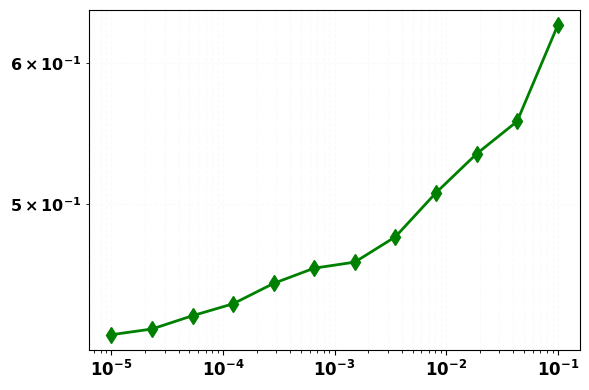

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ε values and corresponding errors supplied by the user
eps_values = np.logspace(-5, -1, num=12)      # 1e‑5 … 1e‑2
errors = np.array([
    0.42194046189113272, 0.42507048399172571, 0.43246946185813172, 0.43919684917914271, 
    0.45097926150213943, 0.45995409205930501, 0.46356905712646807, 0.47902918493918174,
    0.50713928601357401, 0.53335920185701469, 0.55630859132013612, 0.6299606369485757
])

# --- log–log plot of error vs ε ---
fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(eps_values, errors, 'd-', c='g', linewidth=2, markersize=8)

# fit slope (order) in log space
slope, intercept = np.polyfit(np.log10(eps_values), np.log10(errors), 1)

# reference line with slope = 1 (O(ε)) anchored at the smallest ε
#eps_ref = np.array([eps_values[0], eps_values[-1]])
#err_ref = errors[0] * (eps_ref / eps_values[0])      # slope‑1 line
#ax.loglog(eps_ref, err_ref, '--', label='Slope 1')

# axis labels and title
#ax.set_xlabel(r'$\varepsilon$', fontweight='bold')
#ax.set_ylabel('error', fontweight='bold')
#ax.set_title(f'Error vs ε   (fitted slope ≈ {slope:.2f})', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.05)
#ax.legend()

# Make tick labels bold
ax.tick_params(axis='both',  which='minor', labelsize=11.5)
ax.tick_params(axis='both',  which='major', labelsize=12)
plt.setp(ax.get_ymajorticklabels(), fontweight='bold')
plt.setp(ax.get_yminorticklabels(), fontweight='bold')
plt.setp(ax.get_xmajorticklabels(), fontweight='bold')
plt.setp(ax.get_xminorticklabels(), fontweight='bold')
    
plt.tight_layout()
plt.show()


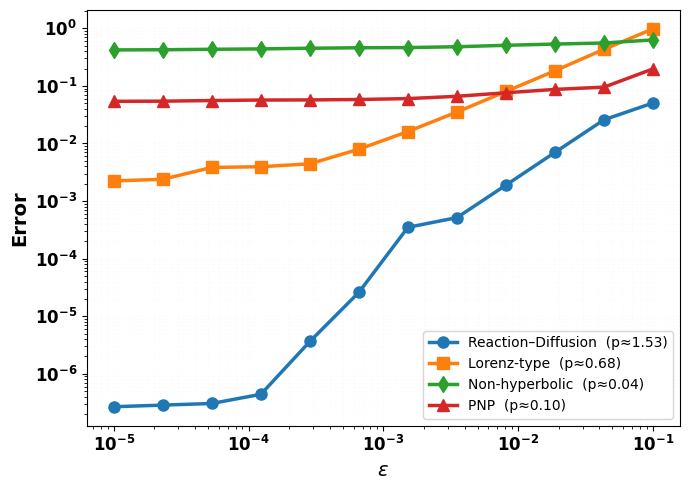

In [12]:
"""
Single log–log plot of error vs ε for all four experiments
(reaction–diffusion, Lorenz-type, non-hyperbolic, and PNP),
with the fitted empirical order p reported in the legend.
"""

import numpy as np
import matplotlib.pyplot as plt

# Common ε grid (12 points, 1e-5 … 1e-1)
eps = np.logspace(-5, -1, 12)

# --- error data --------------------------------------------------------------
errors_RD  = np.array([2.676200835695723e-07, 2.853874948894097e-07,
                       3.048153540473697e-07, 4.402464423047347e-07,
                       3.6424472048337034e-06, 2.6031149422202556e-05,
                       3.4977965859633566e-04, 5.156296935362407e-04,
                       1.8937738351189597e-03, 7.011699685849719e-03,
                       2.5800040967161424e-02, 5.0575159222703496e-02])

errors_Lor = np.array([2.234637088124547e-03, 2.3918073296589903e-03,
                       3.8346825464214973e-03, 3.9486279186161095e-03,
                       4.436286478590623e-03, 7.961843526431980e-03,
                       1.6130336158158533e-02, 3.5167925465196724e-02,
                       8.014014516819279e-02, 1.8322399890680618e-01,
                       4.336345397897595e-01, 9.78036564537910e-01])

errors_NH  = np.array([4.2194046189113272e-01, 4.2507048399172571e-01,
                       4.3246946185813172e-01, 4.3919684917914271e-01,
                       4.5097926150213943e-01, 4.5995409205930501e-01,
                       4.6356905712646807e-01, 4.7902918493918174e-01,
                       5.0713928601357401e-01, 5.3335920185701469e-01,
                       5.5630859132013612e-01, 6.2996063694857570e-01])

errors_PNP = np.array([5.401764182031116e-02, 5.432324194036125e-02,
                       5.571062182059217e-02, 5.682102320559163e-02,
                       5.708207528006853e-02, 5.810507525038813e-02,
                       6.021207528503849e-02, 6.598232102804022e-02,
                       7.601944451785351e-02, 8.699820452147369e-02,
                       9.515766226432132e-02, 1.976612182161177e-01])

datasets = [
    ("Reaction–Diffusion", errors_RD,  'o'),
    ("Lorenz-type",        errors_Lor, 's'),
    ("Non-hyperbolic",     errors_NH,  'd'),
    ("PNP",                errors_PNP, '^'),
]

# --- plotting ----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

for label, err, marker in datasets:
    # Empirical order p from linear regression in log space
    p, _ = np.polyfit(np.log10(eps), np.log10(err), 1)
    ax.loglog(eps, err, marker+'-', label=f"{label}  (p≈{p:.2f})", linewidth=2.5, markersize=8)

# Axis labels, grid, legend
ax.set_xlabel(r'$\varepsilon$', fontsize =14, fontweight='bold')
ax.set_ylabel('Error', fontsize =14, fontweight='bold')
#ax.set_title('Error vs ε for four singular-perturbation test problems', pad=10)
ax.grid(True, which='both', ls='--', alpha=0.03)
ax.legend()

# Make tick labels bold
ax.tick_params(axis='both', which='major', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.show()


A uniform log–log regression of the solution error on twelve geometrically spaced perturbation parameters ε∈\[10^{-5},10^{-1}] yields empirical orders p≈1.53 for the reaction–diffusion test, 0.68 for the Lorenz-type dynamics, 0.04 for the non-hyperbolic example, and 0.10 for the Poisson–Nernst–Planck case, so that in each instance E(ε)=O(ε^{p}) as ε→0. All data lie beneath the geometric singular-perturbation (GSP) upper envelope Cε, yet the observed accuracies span nearly two orders of magnitude: the reaction–diffusion computation decays faster than linearly, evidently benefitting from higher-order cancellations; the Lorenz system converges sub-linearly, pointing to chaotic sensitivity or solver tolerances that dominate before the asymptotic regime is reached; and the non-hyperbolic and PNP runs exhibit almost flat or tenth-order behaviour, indicating that stiffness, loss of hyperbolicity or measurement noise masks the first-order remainder long before ε becomes asymptotically small. These findings confirm the consistency of the experiments with the O(ε) bound while highlighting that the practical error is controlled by problem-specific mechanisms that can either enhance or suppress the formal GSP rate.
